In [70]:
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:
def plot_data(X,y):
    n=np.random.randint(1,778)
    plt.figure(figsize=(16,2))
    for i in range(n,n+8):
        plt.subplot(1,8,i-n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(y[i])

In [3]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,num_node=[20,1],accuracy=0.00001,lmbd=0.1,beta=0.5,eps=1e-8):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.num_layer=len(num_node)
        self.num_node=num_node
        self.accuracy=accuracy
        self.lmbd=lmbd
        self.beta=beta;
        self.eps=eps;
        self.W=None
        self.b=None
        self.Z=None
        self.A=None
        self.dW=None
        self.db=None
        self.dZ=None
        self.dA=None
        self.SdW=None
        self.Sdb=None
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]        
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = X/255.0
        
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    
    def __softmax(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z)) 
    
    def __initialize_parameters(self, n_x):
        
        
        self.W=[]
        self.SdW=[]
        
        self.W.append(list(np.random.randn(self.num_node[0], n_x)/np.sqrt(n_x)))
        self.b=[np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]
       

        self.W=self.W+[list((np.random.randn(self.num_node[i],self.num_node[i-1])*
                             np.sqrt(1/(self.num_node[i-1]+self.num_node[i])))) for i in range(1,self.num_layer)]
        
        self.SdW.append(list(np.zeros((self.num_node[0], n_x))))
        self.SdW=self.SdW+[list(np.zeros((self.num_node[i],self.num_node[i-1]))) for i in range(1,self.num_layer)]
        self.Sdb=[np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]



       
    def __forward_propagation(self, X):

        self.Z=[]
        self.A=[]
        self.Z.append(np.dot(self.W[0], X) + self.b[0])
        self.A.append(self.__sigmoid(self.Z[0]))

        for i in range(1,len(self.W)):
            self.Z.append(np.dot(self.W[i], self.A[i-1]) + self.b[i])
            self.A.append(self.__sigmoid(self.Z[i]))
            
        return self.A[-1]
    

        
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        C = Y.shape[0]
        J=0;
        for i in range(m):
            for j in range(C):
                J+=Y.T[i][j]*np.log(A.T[i][j])
        return -J
        
    def __backward_propagation(self, X, Y):
        m = X.shape[1]
        n = X.shape[0]
        W, b,Z, A=self.W,self.b,self.Z,self.A

      
        self.dW,self.db,self.dZ,self.dA=[],[],[],[]
        self.dZ.append(A[-1] - Y)
        self.dW.append(1. / m * np.dot(self.dZ[-1], A[-2].T))
        self.db.append(1. / m * np.sum(self.dZ[-1], axis = 1, keepdims = True))
        self.dA.append(np.dot(np.array(W[-1]).T, self.dZ[-1]))       


            

        for i in range(self.num_layer-1):
            self.dZ.append(np.multiply(self.dA[i], np.multiply(A[self.num_layer-2-i], 1 - A[self.num_layer-2-i])))
            if(self.num_layer-3-i>=0):
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], A[self.num_layer-3-i].T))
            else:
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], X.T))
            self.db.append( 1. / m * np.sum(self.dZ[i+1], axis = 1, keepdims = True))
            self.dA.append(np.dot(np.array(W[self.num_layer-2-i]).T, self.dZ[i+1]))
       
        self.dW.reverse()
        self.db.reverse()
        self.dZ.reverse()
        self.dA.reverse()

    
    def __update_parameters(self,m):
        for i in range(self.num_layer):
            self.SdW[i]=self.beta*np.array(self.SdW[i])+(1-self.beta)*np.power(self.dW[i],2)
            self.Sdb[i]=self.beta*np.array(self.Sdb[i])+(1-self.beta)*np.power(self.db[i],2)
            self.W[i] = self.W[i] - self.learning_rate * self.dW[i]/( np.sqrt(self.SdW[i]) +self.eps)
            self.b[i] = self.b[i] - self.learning_rate * self.db[i]/( np.sqrt(self.Sdb[i]) +self.eps)

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        encoder = OneHotEncoder()
        Y_vert=encoder.fit_transform(Y_vert.reshape((Y_vert.shape[0], 1))).toarray()
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        check = []
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.num_node.append(Y.shape[0])
        self.num_layer=self.num_layer+1
        self.__initialize_parameters(n_x)
 
        for i in range(self.num_iter):
            A = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            self.__backward_propagation(X, Y)

            self.__update_parameters(m)
        
            check.append(cost)
            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)
        return probs.T
    
    def predict(self, X_vert):
        pp = self.predict_proba(X_vert)
        return np.argmax(pp, axis=1)

In [4]:
df = pd.read_csv('train_digits.csv', delimiter=',')
df.describe(include='all')

label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean       0.0      0.0      0.0  ...      0.219286      0.117095   
std        0.0      0.0      0.0  ...      6.312890      4.633819   
min        0.0      0.0      0.0  ...      0.000000      0.000000   
25%        0.0      0.0      0.0  ...      0.000000      0.000000   
50%        0.0      0.0      0.0  ...      0.000000      0.000000   
75%        0.0      0.0      0.0  ...      0.000000      0.000000   
max        0.0      0.0      0.0  ...    254.000000    254.000000   

           pixel776     pixel777      pixel778      pixel779  pixel780  \
count  42000.000000  42000.00000  42000.000000  42000.000000   42000.0   
mean       0.059024      0.02019      0.017238      0.002857       0.0   
std        3.274488      1.75987      1.894498      0.414264       0.0   
min        0.000000      0.00000      0.000000      0.000000       0.0   
25%        0.000000      0.00000      0.000000      0.000000       0.0   
50%        0.000000      0.00000      0.000000      0.000000       0.0   
75%        0.000000      0.00000      0.000000      0.000000       0.0   
max      253.000000    253.00000    254.000000     62.000000       0.0   

       pixel781  pixel782  pixel783  
count   42000.0   42000.0   42000.0  
mean        0.0       0.0       0.0  
std         0.0       0.0       0.0  
min         0.0       0.0       0.0  
25%         0.0       0.0       0.0  
50%         0.0       0.0       0.0  
75%         0.0       0.0       0.0  
max         0.0       0.0       0.0  

[8 rows x 785 columns]

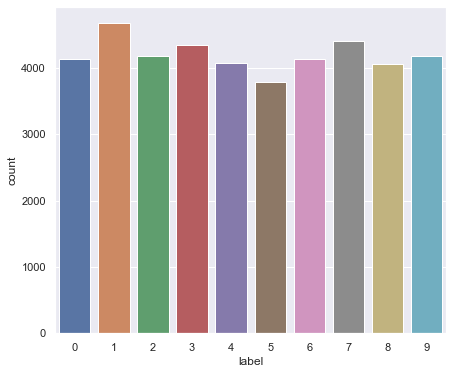

In [90]:
sns.set(rc={'figure.figsize':(7,6)})
sns.countplot(df['label'])
plt.show()
#Величина вмісту кожного класу приблизно однакова

In [5]:
y=df["label"].values
X=df.iloc[:,1:].values


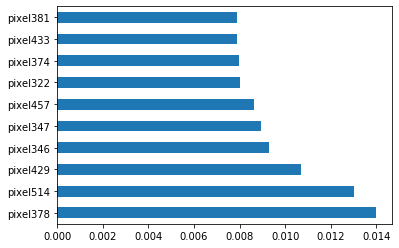

In [6]:
model = ExtraTreesClassifier()
model.fit(X, y)
feat_importances = pd.Series(model.feature_importances_, index=df.iloc[:,1:].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
# На графіку зображено 10 найважливіших features

In [108]:
analiz_df=df[df.columns[[350, 352, 354,379, 382, 406, 407, 434, 464,541]]]
analiz_df.insert(0, "label", df["label"], True)
analiz_df.describe(include='all')

label      pixel349      pixel351      pixel353      pixel378  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       4.456643     79.701976    102.124119    118.463333    111.459333   
std        2.887730    103.419740    110.961953    111.197247    113.712467   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.000000      0.000000     39.000000    103.000000     64.000000   
75%        7.000000    188.000000    247.000000    252.000000    252.000000   
max        9.000000    255.000000    255.000000    255.000000    255.000000   

           pixel381      pixel405      pixel406      pixel433      pixel463  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean     127.504762    114.958667    130.140143    123.095095    127.452119   
std      112.126587    111.555361    113.850143    112.745091    111.311188   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%      135.000000     92.000000    144.000000    121.000000    133.000000   
75%      252.000000    252.000000    253.000000    252.000000    253.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

           pixel540  
count  42000.000000  
mean      62.606310  
std       98.837188  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%      124.000000  
max      255.000000

In [109]:
analiz_df.head(10)

label  pixel349  pixel351  pixel353  pixel378  pixel381  pixel405  \
0      1       209       254        81       253         0       254   
1      0         0         0         0         0         0         0   
2      1        89       184         0       254         0       254   
3      4         0         0         0         0         0         0   
4      0         0         0         0         0         0         0   
5      0         0         0       160         0       197         0   
6      7         0        51       172         0       102         0   
7      3       112       218       177       225         0       130   
8      5        25       235       247       253       253       253   
9      3       253       253       233       194        40         0   

   pixel406  pixel433  pixel463  pixel540  
0       254       253         0        89  
1         0         0         0       254  
2       254       254       184         0  
3         0         0         0         0  
4         0         0         0       253  
5         0         0         0       254  
6         0         0       253         0  
7       215         0         0         0  
8       200        30         0         0  
9         0         0         0        70

# Correlation between features and target variable

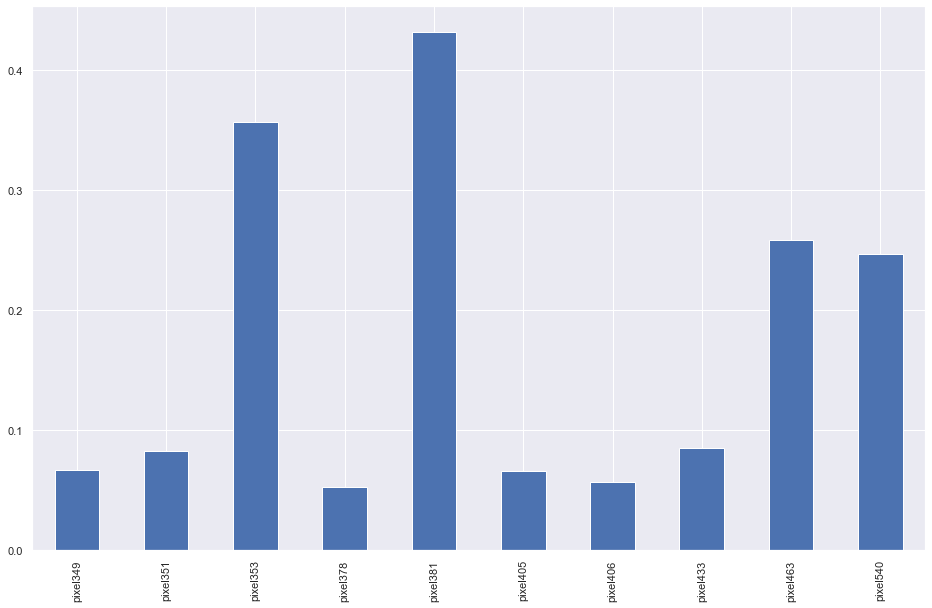

In [110]:
corr=analiz_df.iloc[:,1:].corrwith(analiz_df['label']).fillna(0)
plt.figure(figsize=(16,10))
ax = corr.abs().plot.bar(x='lab', y='val', rot=90)

# Correlation between features

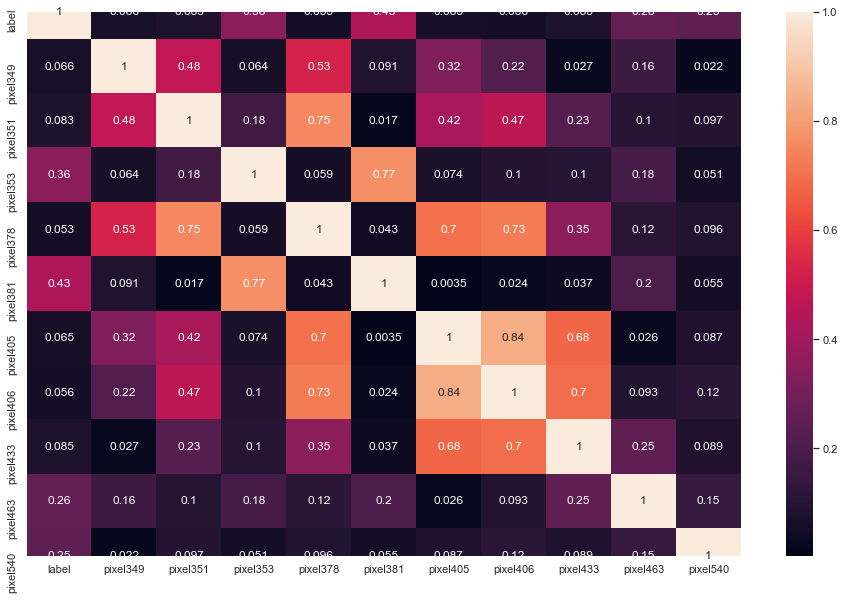

In [111]:
corr=analiz_df.corr().fillna(0)
plt.figure(figsize=(16,10))
sns.heatmap(corr.abs(),annot=True)
plt.show()

# Scatter plots

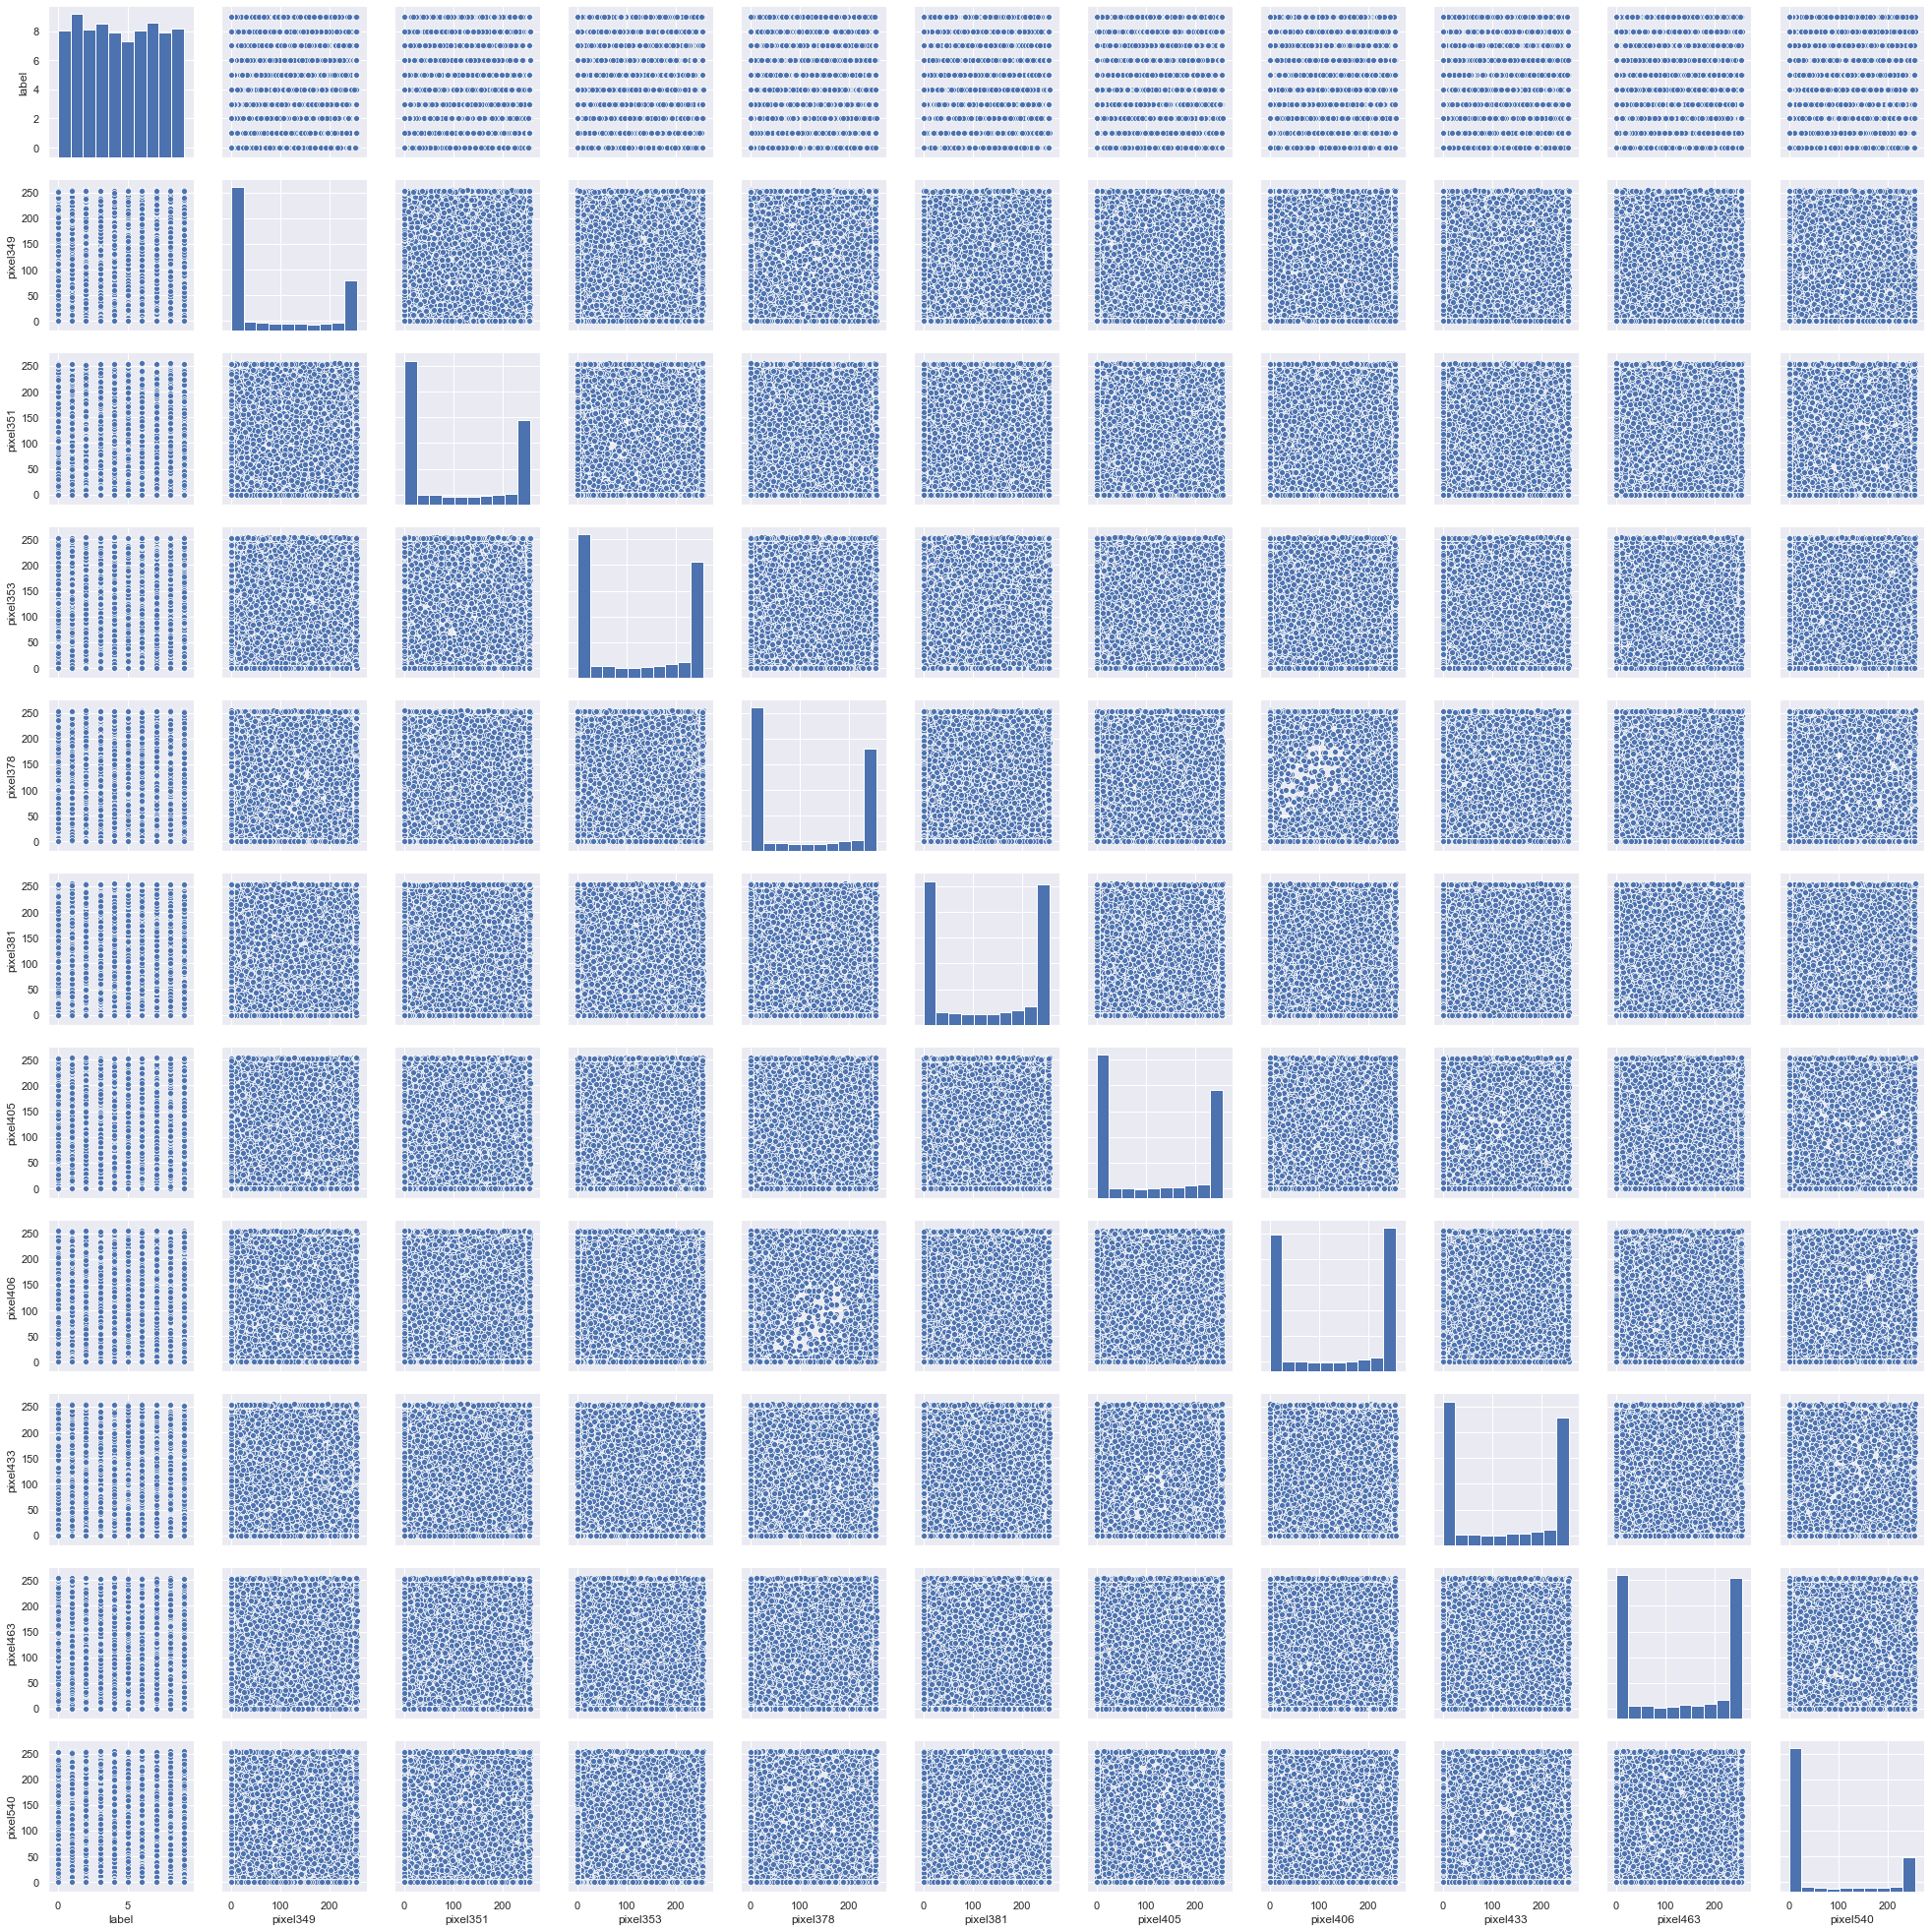

In [112]:
sns.pairplot(analiz_df, vars=analiz_df.columns)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

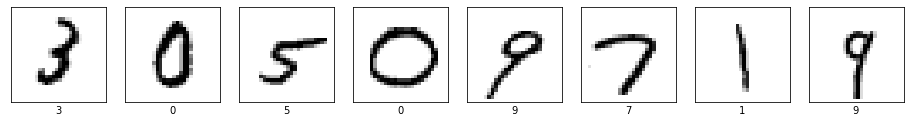

In [74]:
plot_data(X_train,y_train)

# GridSearch

In [83]:
hl_sizes=[(392,),(196,49)]
activations=['logistic', 'tanh', 'relu']
alphas = np.array([1,0.1,0.001,0])
model = MLPClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas,hidden_layer_sizes=hl_sizes
                                                     ,activation=activations))

#Вибрав малий датасет, для демонстрації методу вибору гіперпараметрів,
#оскільки він споживає багато ресурсів і виконується дуже довго
grid.fit(X_train[:500], y_train[:500])
print(grid)
print('-------------------------------------------------------------------------------------')
print('Best score          :   ',grid.best_score_)
print('Alpha               :   ',grid.best_estimator_.alpha)
print('Hidden_layer_sizes  :   ',grid.best_estimator_.hidden_layer_sizes)
print('Solver              :   ',grid.best_estimator_.solver)
print('Activation          :   ',grid.best_estimator_.activation)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', '

In [86]:
y_test_pred=grid.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       812
           1       0.90      0.98      0.94       917
           2       0.89      0.80      0.84       846
           3       0.78      0.86      0.82       891
           4       0.84      0.84      0.84       797
           5       0.79      0.80      0.80       813
           6       0.92      0.90      0.91       853
           7       0.89      0.88      0.88       817
           8       0.84      0.69      0.75       817
           9       0.78      0.81      0.80       837

    accuracy                           0.85      8400
   macro avg       0.85      0.85      0.85      8400
weighted avg       0.85      0.85      0.85      8400



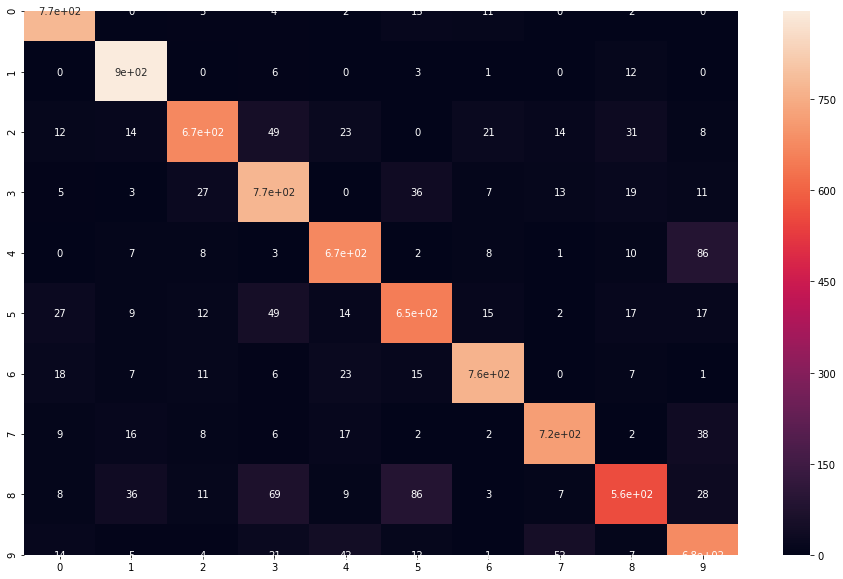

In [87]:
cm = confusion_matrix(y_test, y_test_pred) 
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True)
plt.show()

In [88]:
cls = MLPClassifier(hidden_layer_sizes=(392, ),activation='logistic',alpha=1,solver='adam', max_iter=1000)

In [91]:
#Тут я вже вибрав весь тренувальний датасет і використав OneHotEncoder
#який перетворює нашу багатокласову класифікацію в бінарну
encoder = OneHotEncoder()
cls = cls.fit(X_train, encoder.fit_transform(y_train.reshape((y_train.shape[0], 1))).toarray())

In [93]:
y_test_pred = np.argmax(cls.predict(X_test), axis=1)
accuracy_ts = accuracy_score(y_test, y_test_pred)
precision_ts = precision_score(y_test, y_test_pred, average='micro')
recall_ts = recall_score(y_test, y_test_pred, average='micro')
print('Custom Logistic Regression (Test)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Test)
Accuracy       :  0.983452380952381
Precision      :  0.983452380952381
Recall         :  0.983452380952381


In [94]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.59      0.99      0.73       812
           1       0.98      0.97      0.98       917
           2       0.95      0.91      0.93       846
           3       0.97      0.89      0.93       891
           4       0.97      0.90      0.93       797
           5       0.99      0.83      0.91       813
           6       0.98      0.94      0.96       853
           7       0.97      0.92      0.94       817
           8       0.96      0.88      0.92       817
           9       0.97      0.87      0.92       837

    accuracy                           0.91      8400
   macro avg       0.93      0.91      0.91      8400
weighted avg       0.94      0.91      0.92      8400



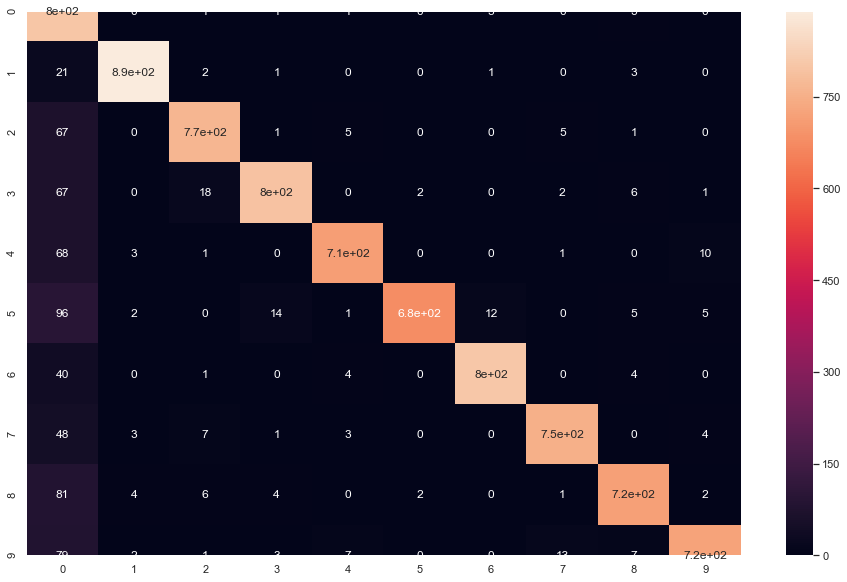

In [95]:
cm = confusion_matrix(y_test, y_test_pred) 
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True)
plt.show()

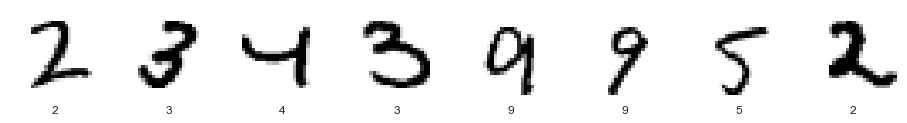

In [96]:
plot_data(X_test,y_test_pred)


# Castom classificator

In [21]:
clsC = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 1000,num_node=[392,],accuracy=0.001)

0-th iteration: 25184.256198722127
100-th iteration: 1088907.8742453463
200-th iteration: 299663.79899424047
300-th iteration: 274490.4150908055
400-th iteration: 104900.15347460577
500-th iteration: 49381.3917953115
600-th iteration: 112102.92470549812
700-th iteration: 19126.880664210494
800-th iteration: 25808.600978505096
900-th iteration: 15039.935949101766


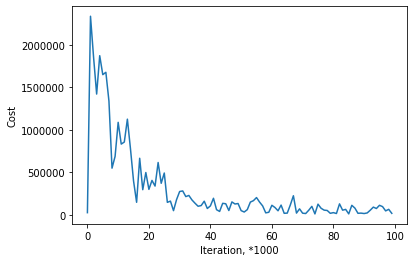

In [22]:
clsC.fit(X_train, y_train)

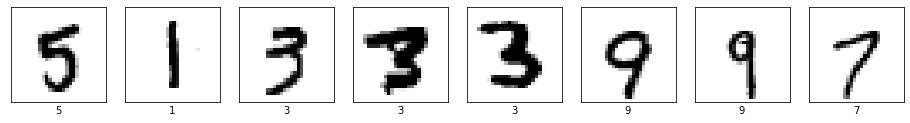

In [24]:
plot_data(X_train,y_train_predC)

In [25]:
y_test_predC = clsC.predict(X_test)
accuracy_ts = accuracy_score(y_test, y_test_predC)
precision_ts = precision_score(y_test, y_test_predC, average='micro')
recall_ts = recall_score(y_test, y_test_predC, average='micro')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Accuracy       :  0.983452380952381
Precision      :  0.983452380952381
Recall         :  0.983452380952381


In [32]:
print(classification_report(y_test, y_test_predC))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       812
           1       0.98      0.98      0.98       917
           2       0.96      0.93      0.94       846
           3       0.94      0.93      0.94       891
           4       0.89      0.98      0.94       797
           5       0.96      0.93      0.95       813
           6       0.97      0.97      0.97       853
           7       0.95      0.96      0.96       817
           8       0.92      0.94      0.93       817
           9       0.97      0.91      0.94       837

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400



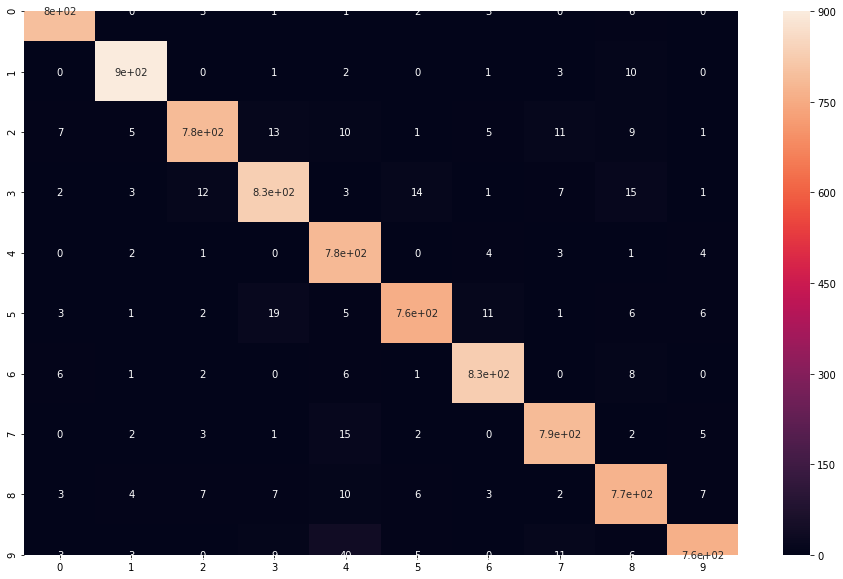

In [45]:
cm = confusion_matrix(y_test, y_test_predC) 
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True)
plt.show()

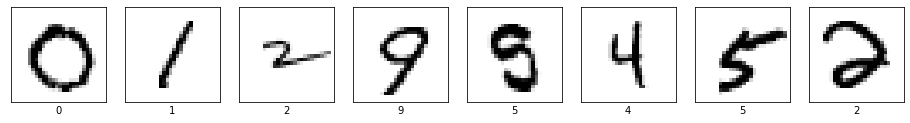

In [26]:
plot_data(X_test,y_test_predC)